# Assignment-2 : Apply T-SNE on Amazon Fine Food Review Dataset

In [48]:
# Importing all the necessary libraries

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer

from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


from tqdm import tqdm
import os

In [3]:
# Reading data from SQLite Table

con=sqlite3.connect("database.sqlite")
Data=pd.read_sql_query("select * from Reviews",con)

In [4]:
print("\nNumber of Reviews: ",Data["Text"].count())
print("\nNumber of Users: ",len(Data["UserId"].unique())) # Unique returns 1-D array of unique values of DataFrame.
print("\nNumber of Products: ",len(Data["ProductId"].unique()))
print("\nShape of Data: ",Data.shape)
print("\n",Data.columns)


Number of Reviews:  568454

Number of Users:  256059

Number of Products:  74258

Shape of Data:  (568454, 10)

 Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454

Number of users: 256,059

Number of products: 74,258

Timespan: Oct 1999 - Oct 2012

Number of Attributes/Columns in data: 10

# Inforamtion about data

# 1.1 Attribute Information of the Dataset:

Id - A unique value starts from 1

ProductId - unique identifier for the product

UserId - unqiue identifier for the user

ProfileName - Name of user profile 

HelpfulnessNumerator - number of users who found the review helpful

HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not

Score - rating between 1 and 5

Time - timestamp for the review

Summary - brief summary of the review

Text - text of the review

# 2.0 Objective : 
Apply TSNE on Bag Of Word,TF-IDF, Word2Vec, TF-IDF Word2Vec

In [5]:
Data['Score'].unique()

array([5, 1, 4, 2, 3], dtype=int64)

In [6]:
# For negative review (Score=1 or 2)
# For positive review (Score = 4 or 5)
# considering review with Score = 3 as neutral
# Let's check how many have score value equal to 3 
print(pd.read_sql_query("select score,count(score) as Total_Count from Reviews where score==3",con))


   Score  Total_Count
0      3        42640


In [7]:
# Since 42,640 Data are having score of 3
# removing reviews having Score = 3

filtered_data = pd.read_sql_query("SELECT * FROM Reviews WHERE Score != 3 ", con) 

In [8]:
# Giving reviews with Score>3 a positive rating (1),and reviews with a score<3 a negative rating (0).

def change_discrite_to_numerical(x):
    if x < 3:
        return 0
    return 1

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(change_discrite_to_numerical) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(2)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


# 3.0 Exploratory Data Analysis 

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


# 3.1 Data Cleaning: Deduplication

(i). It is observed (as shown in the table above) that the reviews data had many duplicate entries. Hence it was  
     necessary to remove duplicates in order to get unbiased results for the analysis of the data.
     
(ii). As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 

(iii). ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

(iv). ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

(v).  It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

(vi). The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."


In [11]:

# Removal of Duplicate entries (Deduplication of entries).
# It will find duplicates on the basis of element contained by subset by default it uses all columns. 

final=sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)
print(final.shape)

(364173, 10)


In [12]:
#Checking to see how much % of data still remains

print("% of Data present in Dataset: {:.2f}".format((final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100))

% of Data present in Dataset: 69.26


In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


# Observation :

1. In the above table It can be seen that in two rows given the value of HelpfulnessNumerator is greater than  
   HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions.

2. HelpfulnessNumerator   : No of people given yes
   HelpfulnessDenominator : No of people given yes and no both included.

3. So HelpfulnessNumerator sholud be always less than HelpfulnessDenominator  

In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
print("Shape of the DataSet: ",final.shape)

#How many positive and negative reviews are present in our dataset?
print("\n",final['Score'].value_counts())

Shape of the DataSet:  (364171, 10)

 1    307061
0     57110
Name: Score, dtype: int64


# 4.0 Text Preprocessing

In the Preprocessing phase we will perform the following in the given order below:-

1. Begin by removing the html tags

2. Remove any punctuations or limited set of special characters like , or . or # etc.

3. Check if the word is made up of english letters and is not alpha-numeric

4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)

5. Convert the word to lowercase

6. Remove Stopwords

7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)


In [16]:
# find number of sentences containing HTML tags
import re
i=0;
for sent in final['Text']:
    if (len(re.findall('<.*?>', sent))):
         i += 1;
print("Number of Sentence Containing HTML Tags : ",i)        

Number of Sentence Containing HTML Tags :  93153


In [17]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [18]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        final_string.append(str1)

    
    #adding a column of CleanedText which displays the data after pre-processing of the review 
    
    final['CleanedText']=final_string 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
    
    # store final table into an SQlLite table for future.
    
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    # we need not to call close() to close because it will automatically close.
    
    with open('positive_words.pkl', 'wb') as f: 
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [19]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query("SELECT * FROM Reviews WHERE Score != 3 ", conn)
    conn.close()
else:
    print("Please the above cell")

In [20]:
# Extracting equal number of random sample of positive and negative score

dfn=final[final.Score==0].sample(n=2500)
dfp=final[final.Score==1].sample(n=2500)
print("Shape of Data \n",dfn.shape,dfp.shape,sep="\n")


Shape of Data 

(2500, 12)
(2500, 12)


In [21]:
# Concatenating positive and negative score DataFrame into one DataFrame
frames=[dfp,dfn]
new_df=pd.concat(frames)
new_df.shape

(5000, 12)

In [22]:
# Displaying two Value of DataFrame
new_df.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
210311,464095,501805,B001OOYNDG,AN7VS5F3XPAQ4,Gretchen E. Paul,2,3,1,1241654400,milton's crackers,We enjoy these crackers so much we are willing...,enjoy cracker much will order line els buy upp...
276980,455587,492563,B003M6HHBE,A2H6IUQM2A99DA,maurypb,0,0,1,1326672000,HiChew: The love child of Gummy Bears and Star...,Mmmm... a cross between Starburst fruit chews ...,mmmm cross starburst fruit chew gummi bear gre...


# 5.0 Bag Of Words

1. To perform Bag of Words CountVectorizer() function is used.

2. It convert a collection of text documents to a matirx of token counts.

3. It returns sparse matrix which contain that (row no , column no and value) corresponding to non zero value in matrix.

4. Example

   [0 0 3 0 4
   
    0 0 5 7 0
   ]
   
   Row No     0 0 1 1
   
   Column No   2 4 2 3
   
   Value    3 4 5 7
   
5. Representing a sparse matrix by a 2D array leads to wastage of lots of memory as zeroes in the matrix are of no use in most of the cases. So, instead of storing zeroes with non-zero elements, we only store non-zero elements.

In [23]:
count_vect=CountVectorizer()
Bow_counts=count_vect.fit_transform(new_df['CleanedText'].values)
print("the type of count vectorizer ",type(Bow_counts))
print("\nthe shape of out text BOW vectorizer ",Bow_counts.get_shape())
print("\nthe number of unique words ", Bow_counts.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>

the shape of out text BOW vectorizer  (5000, 9986)

the number of unique words  9986


In [24]:
# Converting Sparse matrix to Dense Matrix 
y=Bow_counts.todense()


In [25]:
# Displaying the shape
y.shape

(5000, 9986)

# 5.1 Applying TSNE On Bag Of Words Data

In [26]:
from fastTSNE import TSNE
model= TSNE(n_components=2,random_state=0,perplexity=50)
tsne_data= model.fit(y)

In [27]:
# Checking Shape of Data
tsne_data.shape

(5000, 2)

In [28]:
# Extracting Label from Data 

label = new_df['Score']

# Checking Shape of Label
label.shape

(5000,)

In [29]:
# Adding Label to data obtained after applying TSNE

data = np.vstack((tsne_data.T,label)).T

# Checking Shape of Data
data.shape

(5000, 3)

In [30]:
# Creating DataFrame from data obtained after Adding Label To Data obtained after applying TSNE
BOW_df=pd.DataFrame(data,columns=['X','Y','Label'])

# Counting different types of label

BOW_df['Label'].value_counts()

0.0    2500
1.0    2500
Name: Label, dtype: int64

# 5.2 TSNE Plot On Bag Of Words

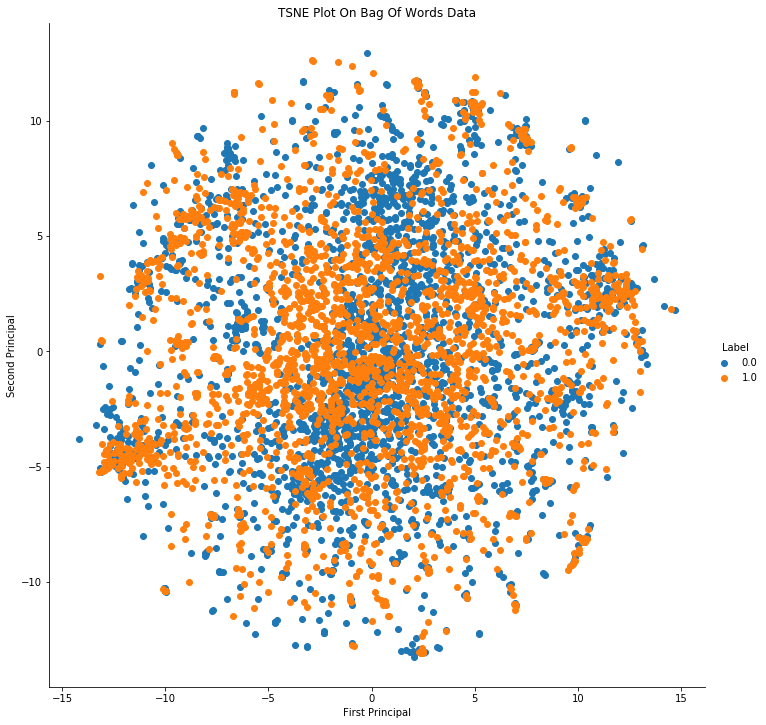

In [31]:
# Plotting 

sns.FacetGrid(data=BOW_df,hue='Label',height=10).map(plt.scatter,'X','Y').add_legend()
plt.title("TSNE Plot On Bag Of Words Data")
plt.xlabel("First Principal")
plt.ylabel("Second Principal")
plt.show()

# 5.3 Conclusion :

1. In the above plot data are overlapping so we can not say it is linearly seperable or not.

.
# 6.0 TF-IDF

In [32]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(new_df['CleanedText'].values)
print("The type of count vectorizer ",type(final_tf_idf))
print("The shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("The number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (5000, 141385)
The number of unique words including both unigrams and bigrams  141385


In [33]:
# Tranforming Sparse Matrix to Dense Matrix

y = final_tf_idf.todense()
y.shape

(5000, 141385)

# 6.1 Applying TSNE On TF-IDF Data

In [34]:
from fastTSNE import TSNE
model=TSNE(n_components=2,random_state=0)
tsne_data= model.fit(y)

In [35]:
label = new_df['Score']
data = np.vstack((tsne_data.T,label)).T
TFIDF_df=pd.DataFrame(data,columns=['X','Y','Label'])
TFIDF_df['Label'].value_counts()

0.0    2500
1.0    2500
Name: Label, dtype: int64

# 6.2 TSNE Plot On TF-IDF

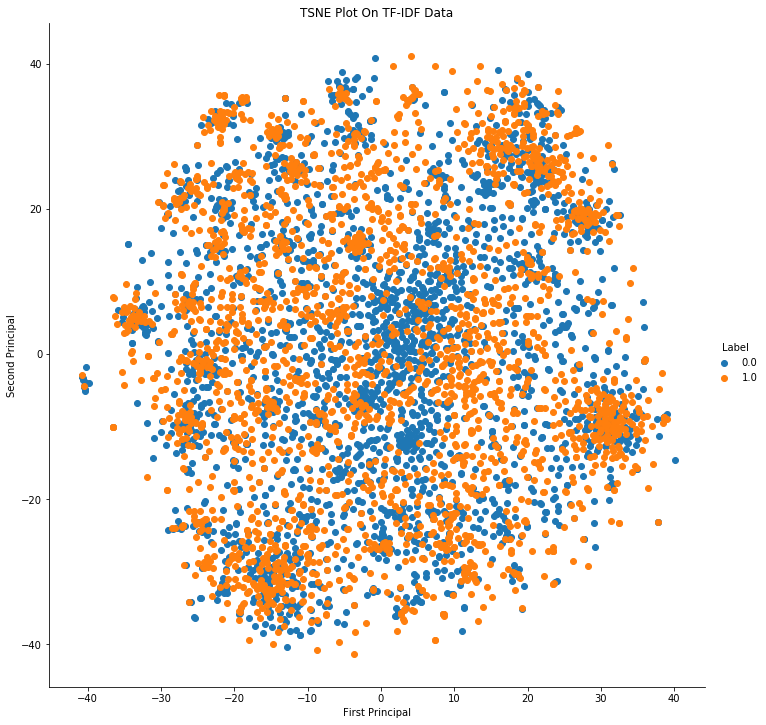

In [36]:
sns.FacetGrid(data=TFIDF_df,hue='Label',height=10).map(plt.scatter,'X','Y').add_legend()
plt.title("TSNE Plot On TF-IDF Data")
plt.xlabel("First Principal")
plt.ylabel("Second Principal")
plt.show()

# 6.3 Conclusion :

1. In this plot also data are overlapping.

# 7.0 Word-To-Vector

In [37]:
# Loading Google News Word2Vector

Ram_gt_16GB=True
want_to_read_sub_set_of_google_w2v = True
want_to_read_whole_google_w2v = True

if not Ram_gt_16GB:
    if want_to_read_sub_set_of_google_w2v and  os.path.isfile('/content/drive/My Drive/AmazonFineFoodReviews/google_w2v_for_amazon.pkl'):
        with open('/content/drive/My Drive/AmazonFineFoodReviews/google_w2v_for_amazon.pkl', 'rb') as f:
            # model is dict object, you can directly access any word vector using model[word]
            model = pickle.load(f)
else:
    if want_to_read_whole_google_w2v and os.path.isfile('/content/drive/My Drive/Colab Notebooks/GoogleNews-vectors-negative300.bin'):
        model = KeyedVectors.load_word2vec_format('/content/drive/My Drive/Colab Notebooks/GoogleNews-vectors-negative300.bin', binary=True)
         

In [38]:
# Training Word2Vec model using own text corpus
i=0
list_of_sent=[]
for sent in new_df['CleanedText']:
    list_of_sent.append(sent.split())

In [39]:
print(new_df['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[1:3])

enjoy cracker much will order line els buy upper peninsula michigan
*****************************************************************
[['mmmm', 'cross', 'starburst', 'fruit', 'chew', 'gummi', 'bear', 'great', 'theyr', 'avail', 'neighborhood', 'korean', 'groceri', 'store', 'dont', 'happen', 'access', 'uniqu', 'candi', 'treat'], ['cat', 'love', 'food', 'tell', 'ingredi', 'also', 'seem', 'high', 'qualiti', 'food', 'debat', 'brand', 'innova', 'evo', 'ultim', 'decid', 'one', 'fish', 'cat', 'absolut', 'love', 'fish', 'figur', 'would', 'like', 'dont', 'like', 'fact', 'potato', 'carb', 'count', 'still', 'relat', 'low', 'would', 'prefer', 'cat', 'ate', 'wet', 'food', 'tri', 'countless', 'time', 'get', 'eat', 'can', 'food', 'luck', 'recent', 'except', 'fish', 'love', 'tri', 'give', 'rare', 'one', 'point', 'rememb', 'food', 'much', 'higher', 'calori', 'stuff', 'wise', 'free', 'feed', 'food', 'ive', 'alway', 'free', 'fed', 'cat', 'yet', 'gain', 'weight', 'food', 'first', 'week', 'give', 'measur', 

In [40]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [41]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:10])

number of words that occured minimum 5 times  3365
sample words  ['enjoy', 'cracker', 'much', 'will', 'order', 'line', 'els', 'buy', 'upper', 'michigan']


In [42]:
w2v_model.wv.most_similar('tasti')

[('overal', 0.9994135499000549),
 ('blueberri', 0.9993277788162231),
 ('prefer', 0.9993239045143127),
 ('your', 0.9992917776107788),
 ('thin', 0.9992701411247253),
 ('lack', 0.9992452263832092),
 ('punch', 0.9992323517799377),
 ('tooth', 0.9992275834083557),
 ('garlic', 0.9991897940635681),
 ('kick', 0.9991853833198547)]

# 7.1 Applying TSNE On Word-To-Vector

In [49]:
token=[]
label=[]

for word in w2v_model.wv.vocab :
    token.append(w2v_model[word])
    label.append(word)
    
print(len(token))    

3365


In [50]:
from sklearn.manifold import TSNE
model=TSNE(perplexity=100,n_components=2,random_state=0)
tsne_data=model.fit_transform(token)

# 7.2 TSNE Plot On Word-To-Vector

In [51]:
x = []
y = []
for value in tsne_data:
    x.append(value[0])
    y.append(value[1])
        

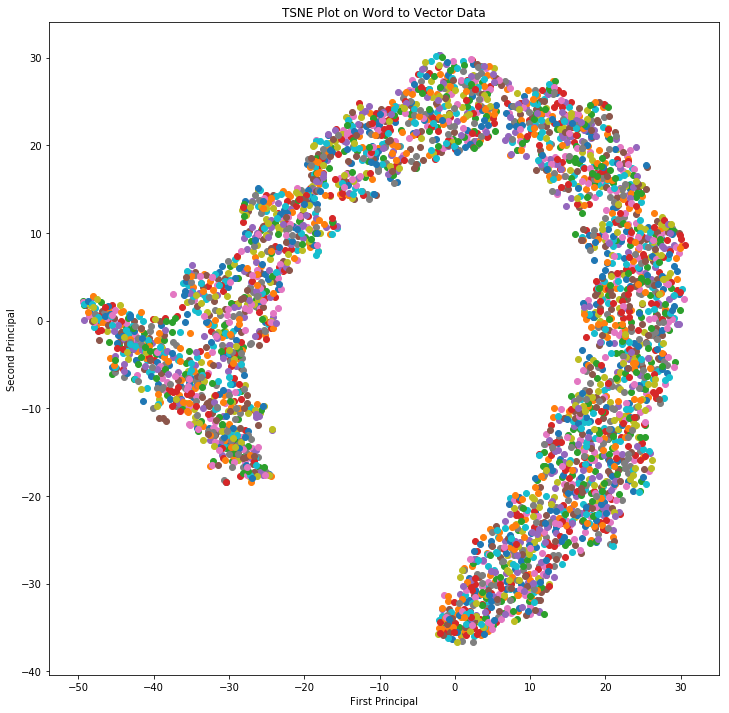

In [52]:
plt.figure(figsize=(12, 12)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
plt.title("TSNE Plot on Word to Vector Data") 
plt.xlabel("First Principal")
plt.ylabel("Second Principal")
plt.show()


# 7.3 Conclusion :

1. Due to overlapping nature of data we can not say anything.

2. We are also not able to see cluster of similar words here.

# 8.0 Average Word to Vector

1. Let r1 is review of a given corpus


2. r1 : w1 w2  w3 w4 w5.....wn


3. Average w2v for r1=V1=(w2v(w1)+w2v(w2)+.....+w2v(wn))/n

In [53]:
sent_vectors = []; # List containing the avg-w2v for each sentence/review is stored in this list

for sent in tqdm(new_df['CleanedText']):
    
    sent_vec = np.zeros(50) # Initialisation of vector so that we could add
    cnt_words =0; # counting num of words with a valid vector in the sentence/review
    for word in sent.split(): 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████| 5000/5000 [00:05<00:00, 780.11it/s]


5000
50


# 8.1 Applying TSNE On Average Word-To-Vector

In [54]:
from sklearn.manifold import TSNE
model=TSNE(n_components=2,random_state=0)
tsne_data= model.fit_transform(sent_vectors)

In [55]:
tsne_data.shape

(5000, 2)

# 8.2 TSNE Plot On Average Word-To-Vector

In [56]:
x = []
y = []
for value in tsne_data:
    x.append(value[0])
    y.append(value[1])
        

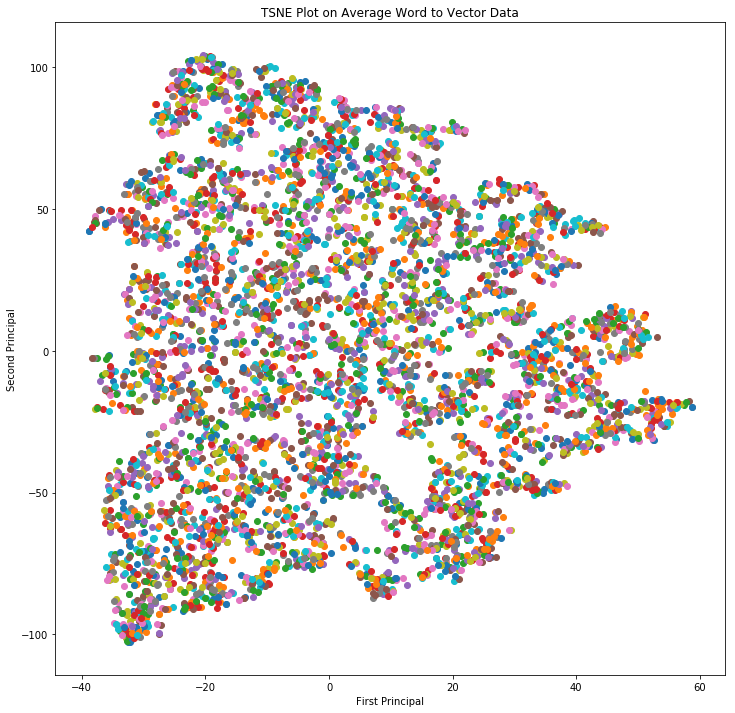

In [57]:
plt.figure(figsize=(12, 12)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
plt.title("TSNE Plot on Average Word to Vector Data") 
plt.xlabel("First Principal")
plt.ylabel("Second Principal")
plt.show()


# 8.3 Conclusion :

1. In this plot also data are overlapping.

# 9.0 TF-IDF Word-To-Vector

In [58]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(new_df['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [59]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████| 5000/5000 [00:07<00:00, 699.11it/s]


# 9.1 Applying TSNE On TF-IDF Word-To-Vector

In [60]:
from sklearn.manifold import TSNE
model=TSNE(n_components=2,random_state=0)
tsne_data= model.fit_transform(sent_vectors)

# 9.2 TSNE Plot On TF-IDF Word-To-Vector

In [61]:
x = []
y = []
for value in tsne_data:
    x.append(value[0])
    y.append(value[1])

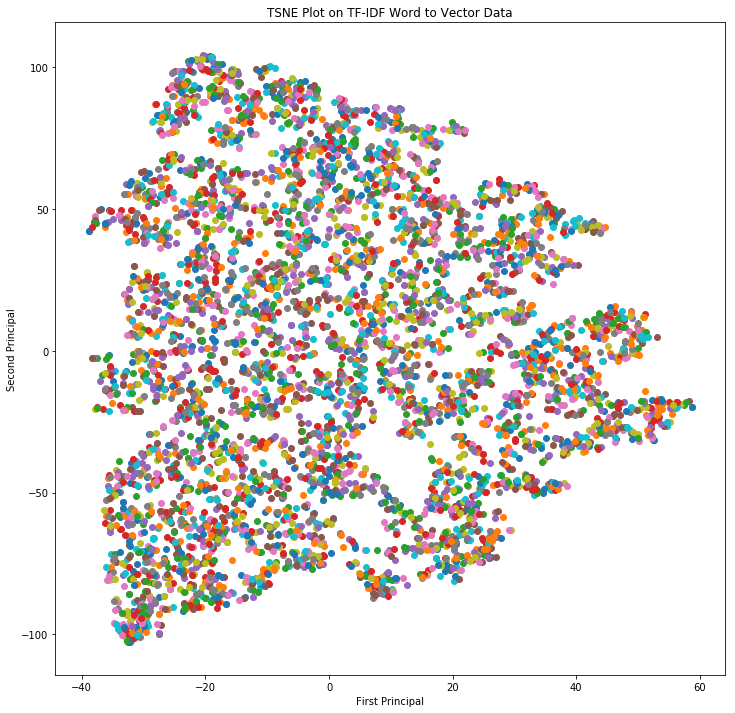

In [62]:
plt.figure(figsize=(12, 12)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
plt.title("TSNE Plot on TF-IDF Word to Vector Data") 
plt.xlabel("First Principal")
plt.ylabel("Second Principal")
plt.show()


# 9.3 Conclusion :

1. In this plot also we have same problem of data overlapping.